In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from performance_measures import c_index, brier_score, weighted_c_index, weighted_brier_score,log_partial_lik
from neural_models import negLogLikelihood, linearCoxPH_Regression, MLP, negLogLikelihood_per_sample
from fairness_measures import individual_fairness, group_fairness, intersect_fairness, individual_fairness_scale, CI, C_index_difference

from sksurv.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import brier_score_loss
from sksurv.metrics import concordance_index_censored, brier_score, integrated_brier_score
from sksurv.metrics import concordance_index_ipcw,cumulative_dynamic_auc
from sksurv.util import Surv
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import argparse
from scipy import optimize
import datetime

Arguments

In [2]:
# parser = argparse.ArgumentParser(description='PyTorch Joint DRO for Survival Analysis')
# parser.add_argument('--dataset', type=str, default="FLC", help="choose from 'FLC', 'SUPPORT', 'SEER'")
# parser.add_argument('--model', type=str, default="Linear", help="choose from 'Linear' and 'MLP'")
# parser.add_argument('--gpuid', type=str, default='0', help='GPU ID')
# parser.add_argument('--epochs', type=int, default=500, metavar='N', help='number of epochs to train')
# parser.add_argument('--lr', type=float, default=0.01, metavar='LR', help='learning rate')
# parser.add_argument('--with_scale', type=bool, default=True, help='use scale for testing')
# parser.add_argument('--eps', type=float, default=0.1, help='a lower bound on the group proportions e.g. {0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5}')
# parser.add_argument('--seed', type=int, default=7, help='Seed')
# parser.add_argument('--protect_index', type=int, default=0, help='protect attribute index')
# parser.add_argument('--train_or_evaluation', type=int, default=0, help='0 for training, 1 for evaluation')
# args = parser.parse_args()
# os.environ['CUDA_VISIBLE_DEVICES'] = args.gpuid

args = {'dataset': 'FLC', 
        'model': 'Linear',
        'gpuid': '0',
        'epochs': 500,
        'lr': 0.01,
        'with_scale': True,
        'eps': 0.1,
        'seed': 7,
        'protect_index': 0,
        'train_or_evaluation': 1}

In [3]:
from compute_survival_function import predict_survival_function  

#The function below ensures that we seed all random generators with the same value to get reproducible results
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

def threshplus(x):
    y = x.copy()
    y[y<0]=0
    return y

def threshplus_tensor(x):
    y = x.clone()
    y[y<0]=0
    return y

def loss_map_chi_factory(loss_values, eps):
    # return lambda x: np.sqrt(2)*(1.0/eps-1.0)*np.sqrt(np.mean(threshplus(loss_values-x)**2.0)) + x
    return lambda x: np.sqrt(2 * ((1.0 / eps - 1.0)** 2.0)+1) * np.sqrt(np.mean(threshplus(loss_values - x) ** 2.0)) + x

def loss_map_chi_factory_tensor(loss_values, eps, opt_eta):
    # return np.sqrt(2)*(1.0/eps-1.0)*torch.sqrt(torch.mean(threshplus_tensor(loss_values-opt_eta)**2.0)) + opt_eta
    return np.sqrt(2 * ((1.0 / eps - 1.0)** 2.0)+1)*torch.sqrt(torch.mean(threshplus_tensor(loss_values-opt_eta)**2.0)) + opt_eta

# Preprocessing

In [4]:
from matplotlib import pyplot as plt

In [5]:
# FLC data:
from utilities import prepare_data
from utilities import check_arrays_survival
from flc_data_preprocess import flc_preprocess
from support_data_preprocess import support_preprocess
from compas_data_preprocess import compas_preprocess
from seer_data_preprocess import seer_preprocess

#Survival Data
if args['dataset'] == 'FLC':
    data_x, data_y, protect_attr = flc_preprocess()
elif args['dataset'] == 'SUPPORT':
    data_x, data_y, protect_attr = support_preprocess()
elif args['dataset'] == 'COMPAS':
    data_x, data_y, protect_attr = compas_preprocess()
elif args['dataset'] == 'SEER':
    data_x, data_y, protect_attr = seer_preprocess()
else:
    print('unknown')

# train-test split
data_X_train, data_X_test, data_y_train, data_y_test, S_train, S_test = train_test_split(data_x, data_y, protect_attr, test_size=0.2,stratify=data_y["death"], random_state=args['seed'])
data_X_train, data_X_dev, data_y_train, data_y_dev, S_train, S_dev = train_test_split(data_X_train, data_y_train, S_train, test_size=0.2,stratify=data_y_train["death"], random_state=args['seed'])
#
data_X_train, data_event_train, data_time_train = check_arrays_survival(data_X_train, data_y_train)
data_X_train, data_event_train, data_time_train, S_train = prepare_data(data_X_train, data_event_train, data_time_train, S_train)

if args['train_or_evaluation']==0:
    data_X_test, data_event_test, data_time_test = check_arrays_survival(data_X_dev, data_y_dev)
    data_X_test, data_event_test, data_time_test, S_test = prepare_data(data_X_test, data_event_test, data_time_test, S_dev)
    data_y_test = data_y_dev
else:
    data_X_test, data_event_test, data_time_test = check_arrays_survival(data_X_test, data_y_test)
    data_X_test, data_event_test, data_time_test, S_test = prepare_data(data_X_test, data_event_test, data_time_test, S_test)
#
intersectionalGroups = np.unique(S_train,axis=0) # all intersecting groups, i.e. black-women, white-man etc 
# data normalization: mean subtraction method to compute euclidean distance
scaler = StandardScaler()
scaler.fit(data_X_train)
data_X_train = scaler.transform(data_X_train)
data_X_test = scaler.transform(data_X_test)

In [ ]:
# from sklearn.metrics.pairwise import pairwise_distances
# data_X_train_sorted = data_X_train
# data_event_train_sorted = data_event_train
# data_time_train_sorted = data_time_train
# t = np.linspace(0, 10000, 100)

# dist_mat_test_to_train = pairwise_distances(data_X_test, data_X_train_sorted, metric='sqeuclidean')
# bw = 1
# kernel = lambda x: np.exp(-x)
# B_mat = kernel(dist_mat_test_to_train/bw)
# # B_mat = B_mat/B_mat.sum(axis = 1, keepdims=True)
# B_mat += 10e-10

# indicator_mat = data_time_train_sorted.reshape(-1, 1) >= data_time_train_sorted.reshape(1, -1)
# #eta = (data_time_train_sorted <= t)*data_event_train_sorted
# eta = (data_time_train_sorted.reshape(-1, 1) <= t.reshape(1, -1))*data_event_train_sorted.reshape(-1, 1)
# product_term_mat = np.power((1 - B_mat/np.matmul(B_mat, indicator_mat))[:, :, np.newaxis], eta[np.newaxis, :, :])
# F_hat = 1 - np.product(product_term_mat, axis=1)

In [ ]:
# t = np.array([1000, 2500, 4000])
# eta = (data_time_train_sorted.reshape(-1, 1) <= t.reshape(1, -1))*data_event_train_sorted.reshape(-1, 1)
# term_mat = np.power((1 - B_mat/np.matmul(B_mat, indicator_mat))[:, :, np.newaxis], eta[np.newaxis, :, :])

# Train/Load Model

## CQR

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
class Local_KM:
    def __init__(self, X, event, time, kernel, bw, is_minmax_normalize = True):
        if is_minmax_normalize:
            scaler = MinMaxScaler()
            self.X = scaler.fit_transform(X)
        else:
            self.X = X
        self.event = event
        self.time = time
        self.kernel = kernel # only support squared euclidean distance
        self.bw = bw

    def predict(self, time_test, X_test):
        dist_mat_test_to_train = pairwise_distances(X_test, self.X, metric='sqeuclidean')
        B_mat = self.kernel(dist_mat_test_to_train/self.bw)
        B_mat += 10e-10
        indicator_mat = self.time.reshape(-1, 1) >= self.time.reshape(1, -1)
        # eta = (self.time.reshape(-1, 1) <= t.reshape(1, -1))*self.event.reshape(-1, 1)
        eta = (self.time.reshape(1, -1) <= time_test.reshape(-1, 1))*self.event.reshape(1, -1)
        product_term_mat = (1 - B_mat/np.matmul(B_mat, indicator_mat))**eta
        F_hat = 1 - np.product(product_term_mat, axis=1)
        return F_hat

In [7]:
local_km_model = Local_KM(data_X_train, data_event_train, data_time_train, lambda x: np.exp(-x), 0.001)
F_hat = local_km_model.predict(data_time_train, data_X_train)

In [8]:
# CQR augmented data
tau = 0.5
augment_index = np.where(((1 - data_event_train)*(F_hat < tau)))[0]
weight_train = np.ones(len(data_event_train))
weight_train[augment_index] = ((tau - F_hat)/(1 - F_hat))[augment_index]
weight_train = np.concatenate([weight_train, 1 - weight_train[augment_index]])

n_augment = len(augment_index)
augment_index = np.concatenate([np.arange(len(data_event_train)), augment_index])
data_X_train_augmented = data_X_train[augment_index]
data_event_train_augmented = data_event_train[augment_index]
data_time_train_augmented = np.concatenate([data_time_train, np.repeat(data_time_train.max()*100, n_augment)])

In [9]:
from sklearn.linear_model import QuantileRegressor
cqr_model = QuantileRegressor(quantile=tau, alpha=0.0, fit_intercept=True, solver='highs')
cqr_model.fit(data_X_train_augmented, data_time_train_augmented, sample_weight=weight_train)

QuantileRegressor(alpha=0.0, solver='highs')

In [12]:
cqr_model.predict(data_X_train)

array([5234.51999897, 6127.37171657, 5563.16968979, ..., 5101.681327  ,
       2221.937069  , 1202.7923661 ])

In [11]:
np.exp(cqr_model.predict(data_X_train)).max()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3440\133484366.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(cqr_model.predict(data_X_train)).max()


inf

In [107]:
np.mean(data_time_train <= cqr_model.predict(data_X_train))

0.773169279618972

In [114]:
1 - np.array([y[0] for y in data_y]).mean()

0.7245364490728982

(array([ 253.,  207.,  168.,  199.,  316.,  293.,  339.,  545., 1065.,
        1654.]),
 array([   0. ,  517.7, 1035.4, 1553.1, 2070.8, 2588.5, 3106.2, 3623.9,
        4141.6, 4659.3, 5177. ]),
 <BarContainer object of 10 artists>)

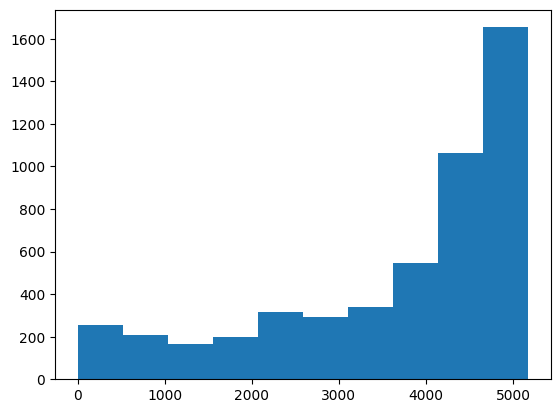

In [13]:
plt.hist(data_time_train)

(array([2.000e+00, 1.000e+00, 1.000e+00, 6.000e+00, 3.300e+01, 1.480e+02,
        5.630e+02, 1.275e+03, 1.843e+03, 1.167e+03]),
 array([-4249.53017904, -3147.3471846 , -2045.16419015,  -942.9811957 ,
          159.20179875,  1261.38479319,  2363.56778764,  3465.75078209,
         4567.93377654,  5670.11677098,  6772.29976543]),
 <BarContainer object of 10 artists>)

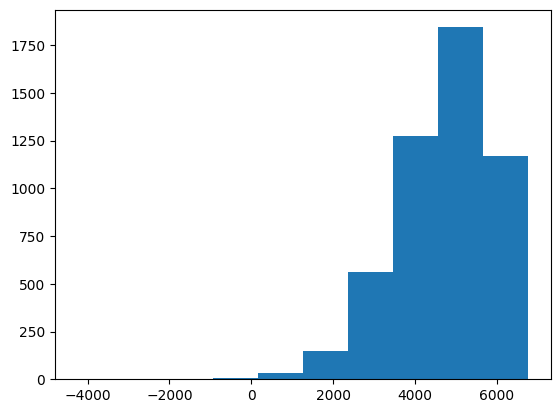

In [14]:
plt.hist(cqr_model.predict(data_X_train))

In [44]:
np.exp(10)

22026.465794806718

In [48]:
data_X_train_augmented@cqr_model.coef_ + cqr_model.intercept_

array([7349.38831067, 9675.86232845, 8459.92962799, ..., 8274.99226838,
       8910.18942779, 7473.6985098 ])

In [35]:
np.exp(cqr_model.predict(data_X_train_augmented))

array([22241.92027466, 74366.58826611, 42851.98037444, ...,
       38964.05500253, 51005.85396553, 25688.60302097])

## DRO-COX

In [15]:
# hyperparameters of the model
input_size = data_X_train.shape[1]
output_size = 1

# intialize model and optimizar
# initialize cox PH model   
if args['model'] == 'Linear':
    coxPH_model = linearCoxPH_Regression(input_size,output_size)
if args['model'] == 'MLP':
    coxPH_model = MLP(input_size, output_size)
# Loss and optimizer
criterion = negLogLikelihood()
criterion_per_sample = negLogLikelihood_per_sample()
optimizer = optim.Adam(coxPH_model.parameters(),lr = args['lr']) # adam optimizer

# training cox ph model 
data_X_train = Variable((torch.from_numpy(data_X_train)).float())
data_event_train = Variable((torch.from_numpy(data_event_train)).float()) 
data_time_train = Variable((torch.from_numpy(data_time_train)).float()) 
  
data_X_test = Variable((torch.from_numpy(data_X_test)).float())

In [16]:
# Train model
saved_model_name = "saved_models_syswong/DRO_COX_{}_{}_lr_{}_seed_{}_sensitive_{}_alpha_{}"\
    .format(args['dataset'], args['model'], args['lr'], args['seed'], args['protect_index'], args['eps'])
if args['train_or_evaluation'] == 0:
    print('Model Training')
    starttime = datetime.datetime.now()
    #%% stochastic method
    for epoch in range(args['epochs']):
        #for batch in range(0,np.int64(np.floor(len(data_X_train)/mini_batch))*mini_batch,mini_batch):

        # backward propagation
        outputs = coxPH_model(data_X_train)
        per_sample_losses = criterion_per_sample(outputs, data_event_train)  # loss between prediction and target
        chi_loss_np = loss_map_chi_factory(per_sample_losses.detach().numpy(), args['eps'])
        cutpt = optimize.fminbound(chi_loss_np, np.min(per_sample_losses.detach().numpy()) - 1000.0, np.max(per_sample_losses.detach().numpy()))
        loss = loss_map_chi_factory_tensor(per_sample_losses, args['eps'], cutpt)
        optimizer.zero_grad() # zero the parameter gradients
        loss.backward()
        optimizer.step()
        # print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, args['epochs, loss.item()))

    endtime = datetime.datetime.now()
    time = (endtime - starttime).seconds
    print('Training Time:', time)
    if not os.path.exists('saved_models_syswong'):
        os.makedirs('saved_models_syswong')
    torch.save(coxPH_model.state_dict(), saved_model_name)
else:
    print('Load the Saved Model')
    coxPH_model.load_state_dict(torch.load(saved_model_name))

Load the Saved Model


# Evaluation

In [21]:
#%% Evaluate the model
# import sys
# sys.stdout=open("typical_Cox_PH_output_Batch.txt","w")
#Measuring the Performance of Survival Models
# linear predictor for train data
with torch.no_grad():
    base_prediction = coxPH_model(data_X_train)
    base_prediction = (base_prediction.numpy()).reshape((-1,)) # beta \dot x
# linear predictor for test/dev data
with torch.no_grad():
    model_prediction = coxPH_model(data_X_test)
    model_prediction = (model_prediction.numpy()).reshape((-1,)) # beta \dot x

In [ ]:
print('----------------------Accuracy Measures----------------------')
# C-index
skSurv_result_test = concordance_index_censored(data_event_test, data_time_test, model_prediction)
print(f"skSurv implemented C-index for test data: {skSurv_result_test[0]: .4f}")

# integrated brier score
data_event_train = data_event_train.numpy().astype(bool)
data_time_train = data_time_train.numpy()
survFunction_test = predict_survival_function(base_prediction, data_event_train, data_time_train, model_prediction)

percentiles = [100]
tmp_IBS_from_sksurv = np.zeros(len(percentiles))
min_time = 0
if data_time_train.min()>data_time_test.min():
    min_time = data_time_train.min()
else:
    min_time = data_time_test.min()
for t in range(len(percentiles)):
    times_range = np.linspace(min_time, np.percentile(data_time_test, percentiles[t]), num=50, endpoint=False)
    preds_ibs = np.asarray([[fn(i_t) for i_t in times_range] for fn in survFunction_test])
    tmp_IBS_from_sksurv[t] = integrated_brier_score(data_y_train, data_y_test, preds_ibs, times_range)
    print("integrated brier score from sksurv (percentile {}): {:0.4f}".format(percentiles[t], tmp_IBS_from_sksurv[t]))

# Time-dependent Area under the ROC
survival_train = np.dtype([('event', data_event_train.dtype), ('surv_time', data_time_train.dtype)])
survival_train = np.empty(len(data_event_train), dtype=survival_train)
survival_train['event'] = data_event_train
survival_train['surv_time'] = data_time_train

survival_test = np.dtype([('event', data_event_test.dtype), ('surv_time', data_time_test.dtype)])
survival_test = np.empty(len(data_event_test), dtype=survival_test)
survival_test['event'] = data_event_test
survival_test['surv_time'] = data_time_test

# event_times = np.arange(np.min(data_time_test), np.max(data_time_test) / 2, 75)
event_times = np.percentile(data_time_test, np.linspace(5, 81, 15))
# event_times = np.percentile(data_y['futime'], np.linspace(5, 81, 15))

test_auc, test_mean_auc = cumulative_dynamic_auc(survival_train, survival_test, model_prediction, event_times)

print(f"Time-dependent Area under the ROC: {test_mean_auc: .4f}")

# log partial likelihood
log_lik = log_partial_lik(model_prediction.reshape(-1, 1), data_event_test.reshape(-1, 1))
print(f"Log partial likelihood: {log_lik: .4f}")

----------------------Accuracy Measures----------------------
skSurv implemented C-index for test data:  0.7916
integrated brier score from sksurv (percentile 100): 0.1332
Time-dependent Area under the ROC:  0.8150
Log partial likelihood: -7.0842


In [28]:
print('----------------------Fairness Measures----------------------')
# %% C_index_difference between groups for fairness measure

CI_score = CI(model_prediction, data_event_test, data_time_test, S_test[:, args["protect_index"]])
print(f"Concordance Imparity (CI) score (%) for test data: {CI_score: .2f}")

# %% individual fairness measures
data_X_test_for_distance = data_X_test.numpy()
data_X_test_for_distance = data_X_test_for_distance / np.linalg.norm(data_X_test_for_distance, axis=1, keepdims=1)


if args["with_scale"]:
    scale_measure = 0.01
    F_I = individual_fairness_scale(model_prediction, data_X_test_for_distance, scale_measure)
    print(f"F_I individual fairness metric with scale={scale_measure: .4f}: {F_I: .4f}")
else:
    F_I = individual_fairness(model_prediction, data_X_test_for_distance)
    print(f"F_I individual fairness metric: {F_I: .4f}")

# %% group fairness measures - age or race or gender
F_G = group_fairness(model_prediction, S_test[:, args["protect_index"]])
print(f"F_G group fairness metric (for protect): {F_G: .4f}")


# %% intersectional fairness measures
F_S = intersect_fairness(model_prediction, S_test, intersectionalGroups)
print(f"F_S intersectional fairness metric: {F_S: .4f}")


# %% average fairness measures
F_A = (F_I + F_G + F_S) / 3
print(f"F_A average fairness metric: {F_A: .4f}")


----------------------Fairness Measures----------------------
Concordance Imparity (CI) score (%) for test data:  0.11
F_I individual fairness metric with scale= 0.0100:  0.0023
F_G group fairness metric (for protect):  0.0098
F_S intersectional fairness metric:  0.0275
F_A average fairness metric:  0.0132


In [37]:
data_X_train.max(axis = 0)

torch.return_types.max(
values=tensor([ 3.3241, 24.4862,  1.5910, 21.6721, 16.7062,  1.1111]),
indices=tensor([4256, 2949,   42, 3068, 4712,    0]))